# Nonlinear Dimensionality Reduction
Due to the strong assumptions made regarding the possible function space of the linear mapping, $~f: \mathcal{R}^{m} \rightarrow \mathcal{R}^{n}$ that we can exctract from Principal Components Analysis (PCA), it is helpful to consider other dimensionality reduction techniques in order to better understand the structure of high dimensional data. An autoencoder is a neural network that learns an isomorphic mapping between two sets, $~\Phi: \mathcal{R}^{m} \rightarrow \mathcal{R}^{n}$. Because autoencoders are neural networks that apply non-linear activation functions to their inputs, this type of network is able to learn *non-linear* mappings from high dimensional space to a lower dimensional *latent space* from which we can get a sense of the high dimensional structures of a dataset in a form that we can more easily interpret visually.  

In [1]:
import os
import pandas as pd
import time
from tqdm import tqdm
import glob
import numpy as np
from utils.input_pipeline import *
#TODO: Try the variational approach instead.
#TODO: instead of solving for a small dimension representation, then traiing a RF on this...make the dims larger and try a linear model instead?

### Loading the data
The ligand data is stored within a series of seperate ~50mb chunks on disk written as .csv (future improvement will be to move this to .h5) flat files. Each chunk of data has the same number of feature columns with varying number of rows, is loaded and stored as an element in a list from which the contents will be concatenated as a single dataframe. Several methods for loading the data were considered however the ease of use pandas for performing necessary data manipulation/formatting combined with the efficiency of numpy makes it possible to use a large number of machine learning libraries to learn on the data rather than being restricted to any builtin functionality of other utilities.
The scikit-learn library, keras, and tensorflow are among the most powerful and robust machine learning libraries avilable for python, each are compatible with numpy arrays from which pandas dataframes act as a wrapper to provide sql like functionality.  

In [2]:
def data_gen(file_path, batch_steps,categorical=False, sample_size=None, features_list=None, mode=None, conformation=None):
    #decide upon receptor versus protein for naming conventions
    receptor_list = list(h5py.File(file_path,'r'))
    while(1):
        random.shuffle(receptor_list)
        
        X,y = load_protein(file_path, protein_name=receptor_list[0], sample_size=None,
                               features_list=features_list,mode=mode, conformation=conformation)
        X = Normalizer().fit_transform(Imputer(strategy="median").fit_transform(np.nan_to_num(X)))
        y = y.flatten()
        
        positives = X[y==1,:]
        negatives = X[y==0,:]
        for step in range(batch_steps):
            negatives_to_keep = np.random.choice(negatives.shape[0],sample_size,replace = True)

            X_batch = np.vstack((negatives[negatives_to_keep],positives))
            X_batch = np.vstack((X_batch,positives))
            y_batch = np.hstack((y[y==0][negatives_to_keep],y[y==1]))
            y_batch = np.hstack((y_batch,y[y==1]))
            if categorical is True:
                yield X_batch, to_categorical(y_batch)
            else:
                yield X_batch, y_batch
                
with open("data/preprocessed_features.csv", "r") as input_file:
    feature_list = []
    for line in input_file:
        line = line.strip('\n')
        feature_list.append(line)
        
print(len(feature_list))

890


In [3]:
print("loading data...")
t0 = time.time()
X,y = load_data("data/full_26_kinase_data.h5",features_list=feature_list)
t1 = time.time()
print("data loaded in",(t1-t0),"seconds.")

  0%|          | 0/26 [00:00<?, ?it/s]

loading data...
loading 26 proteins.


100%|██████████| 26/26 [02:56<00:00,  3.64s/it]

data loaded in 176.48119711875916 seconds.


Store the result of dropping the label column from the dataframe as the input data $X$. In order to preserve the number of training examples, impute the missing values as the average values of their respective column from the input matrix.

In [4]:
from sklearn.preprocessing import Imputer

X = Imputer().fit_transform(X)


In [5]:
from sklearn.preprocessing import normalize

X = normalize(X)


In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [33]:
import tensorflow as tf
import keras.backend as K



from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.layers.advanced_activations import PReLU
from keras import optimizers, objectives, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error


K.set_session(tf.Session(config=tf.ConfigProto(inter_op_parallelism_threads=10,
                                        intra_op_parallelism_threads=10)))

num_epochs = 10
encoding_dim = 460
learning_rate = 1e-3

input_data = Input(shape=(X.shape[1],))
alpha = 'glorot_uniform'

encoded = Dense(int(np.ceil(X.shape[1]/2)),kernel_regularizer=regularizers.l2(0.01))(input_data)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(int(np.ceil(X.shape[1]/16)))(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(int(np.ceil(X.shape[1]/16)))(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(encoding_dim)(encoded)
encoded = Dropout(0.5)(encoded)

encoded = PReLU(alpha_initializer=alpha)(encoded)

decoded = Dense(int(np.ceil(X.shape[1]/16)))(encoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(int(np.ceil(X.shape[1]/16)))(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(int(np.ceil(X.shape[1]/16)))(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(X.shape[1])(decoded)

## Model Description: Encoder

In [34]:
encoder = Model(input_data, encoded)
print (encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 890)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 445)               396495    
_________________________________________________________________
p_re_lu_29 (PReLU)           (None, 445)               445       
_________________________________________________________________
dense_36 (Dense)             (None, 56)                24976     
_________________________________________________________________
p_re_lu_30 (PReLU)           (None, 56)                56        
_________________________________________________________________
dense_37 (Dense)             (None, 56)                3192      
_________________________________________________________________
p_re_lu_31 (PReLU)           (None, 56)                56        
__________

## Model Description: Autoencoder

In [35]:
autoencoder = Model(input_data, decoded)
print (autoencoder.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 890)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 445)               396495    
_________________________________________________________________
p_re_lu_29 (PReLU)           (None, 445)               445       
_________________________________________________________________
dense_36 (Dense)             (None, 56)                24976     
_________________________________________________________________
p_re_lu_30 (PReLU)           (None, 56)                56        
_________________________________________________________________
dense_37 (Dense)             (None, 56)                3192      
_________________________________________________________________
p_re_lu_31 (PReLU)           (None, 56)                56        
__________

## Model Decription: Decoder


In [36]:
encoded_input = Input(shape=(encoding_dim,))

decoder = Model(encoded_input,autoencoder.layers[-1](autoencoder.layers[-2](autoencoder.layers[-3](autoencoder.layers[-4](
    autoencoder.layers[-5](autoencoder.layers[-6](autoencoder.layers[-7](autoencoder.layers[-8](encoded_input)))))))))

print (decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 460)               0         
_________________________________________________________________
p_re_lu_32 (PReLU)           (None, 460)               460       
_________________________________________________________________
dense_39 (Dense)             (None, 56)                25816     
_________________________________________________________________
p_re_lu_33 (PReLU)           (None, 56)                56        
_________________________________________________________________
dense_40 (Dense)             (None, 56)                3192      
_________________________________________________________________
p_re_lu_34 (PReLU)           (None, 56)                56        
_________________________________________________________________
dense_41 (Dense)             (None, 56)                3192      
__________

In [39]:
autoencoder.compile(optimizer=optimizers.adam(lr=1e-4),loss=objectives.mean_squared_error,metrics=['mse'])

In [40]:
from keras.callbacks import TensorBoard
batch_size = 10
autoencoder.fit(X_train,X_train,epochs=1,batch_size=batch_size,shuffle=True,verbose=1,callbacks=[TensorBoard(log_dir='logs/'+str(time.time()), histogram_freq=1, write_graph=True, write_grads=True)])

Epoch 1/1
289428/289428 [==============================] - 191s - loss: 0.0414 - mean_squared_error: 2.9270e-05   


In [41]:
#with K.get_session():

#still need to use train/test splits to properly evaluate performance
enc_red_x = encoder.predict(X_test)
enc_recon_x = decoder.predict(enc_red_x)
enc_error = mean_squared_error(X_test,enc_recon_x)
print("Autoencoder Reconstruction Error: ",enc_error)

Autoencoder Reconstruction Error:  2.06543826428e-05


/global/homes/w/wdjo224/anaconda3/envs/protein_binding/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 33284680 but corresponding boolean dimension is 72358
  
/global/homes/w/wdjo224/anaconda3/envs/protein_binding/lib/python3.6/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 33284680 but corresponding boolean dimension is 72358
  import sys


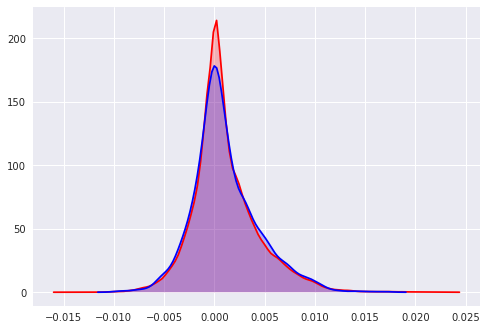

In [42]:
import matplotlib.pyplot as plt
#from scipy.stats import gaussian_kde
import seaborn as sns


sns.kdeplot(enc_red_x.flatten()[y_test.flatten()==0],shade=True, color="r")
sns.kdeplot(enc_red_x.flatten()[y_test.flatten()==1],shade=True, color="b")
plt.show()


Why is there so much overlap between the two sets? Need more features? Don't normalize the data?
### This is may be evidence of a biased estimation of the identity function. 
The values corresponding to the positive class are nearly irrelevant considering the much larger class of negatives. SO to get a low reconstruction error, just map all of the negatives correctly.

## Save the features as an additional set to test on

In [ ]:
output_features = pd.DataFrame({"features":encoder.predict(X),"labels":y})
print(output_features.shape)
#output_features.to_csv("preprocessed_features_autoencoder.csv",header=True,index=False)


In [64]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score

enc_x_train,enc_x_test,enc_y_train,enc_y_test = train_test_split(encoder.predict(X),y.flatten(),stratify=y.flatten()
                                                                 ,test_size=0.2)
train_f1_list = []
test_f1_list = []
f1_list = []
for i in range(1,20):
    rforest= RandomForestClassifier(n_estimators = i,n_jobs=10)

    rforest.fit(enc_x_train,enc_y_train)
    enc_preds_train = rforest.predict(enc_x_train)
    enc_preds_test = rforest.predict(enc_x_test)
    test_f1_list.append(f1_score(enc_preds_test,enc_y_test))
    train_f1_list.append(f1_score(enc_preds_train,enc_y_train))


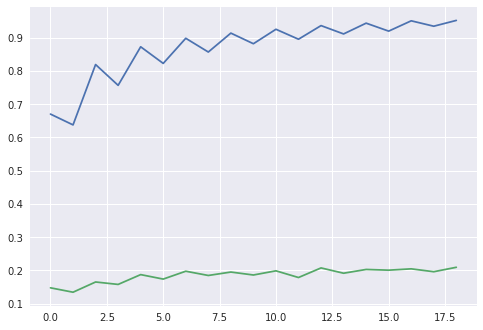

In [66]:
import matplotlib.pyplot as plt

plt.plot(train_f1_list,label="train_f1")
plt.plot(test_f1_list,label="test_f1")
plt.show()

In [61]:
enc_preds_train = rforest.predict(enc_x_train)

enc_accuacy_train = accuracy_score(enc_preds_train,enc_y_train)
enc_f1_train = f1_score(enc_preds_train,enc_y_train)

print("train\t enc_accuracy",enc_accuacy_train,"\tenc_f1-score",enc_f1_train)

train	 enc_accuracy 0.99792003538 	enc_f1-score 0.958025380003


In [62]:
enc_preds_test = rforest.predict(enc_x_test)

enc_accuacy_test = accuracy_score(enc_preds_test,enc_y_test)
enc_f1_test = f1_score(enc_preds_test,enc_y_test)

print("test\t enc_accuracy",enc_accuacy_test,"\tenc_f1-score",enc_f1_test)

test	 enc_accuracy 0.972345835982 	enc_f1-score 0.190861302062
